# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## Asignación de vuelos a gates en aeropuerto

Esta  notebook implementa un algoritmo genético monoobjetivo para la resolución de la asignación de vuelos a gates. Los operadores de cruzamiento y mutación NO aseguran que los individuos representen vuelos diferentes y gates diferentes.

#### Representacion de Individuo:

Un objeto Individual representaa una determinada asignacion de un subconjunto de vuelos (almacenado en <b>list_of_flights</b>) a un conjunto de gates (almacenado en <b>chromosome</b>). La lista de gates disponibles que se pueden asignar a los vuelos se almacena en la variable <b>allele_pool</b>  del individuo. Ver el siguiente grafico ilustrativo:

<img src="EjemploIndividuoAvion.jpg">



In [1]:
import sys
import time
import numpy as np
import random
from random import seed, randint, sample, uniform, randrange
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd

### Clase <b>Individual</b>

Esta es una clase para definir a un individuo de la población. Cada individuo posee un cromosoma, los vuelos a asignar, todos los posibles alelos y su respectivo fitness. Además, los métodos de esta clase permiten realizar el cruzamiento (crossover) y la mutación (mutation) sobre el cromosoma del individuo.

In [2]:
# Clase que implementa el individuo y sus operadores
class Individual(object):
    
    # El constructor recibe la lista de vuelos que representa el individuo y los gates asignados, asi como el pool de flights y gates
    def __init__(self, flights, gates, flights_pool, gates_pool):  
        self.flights = flights[:]
        self.gates = gates[:]
        self.flights_pool = flights_pool
        self.gates_pool = gates_pool
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
      
        c1=True
        c2=True
        c3=True
        c4=True
        c=0
        s=0
        while (c1 or c2 or c3 or c4) == True:
          c = randrange(len(self.gates))    # escoge aleatoriamento una posicion en la lista gates
          s = randrange(len(self.flights))  # escoge aleatoriamento una posicion en la lista vuelos(fligths)
          vh1=self.flights[:s] + other.flights[s:]
          vh2=other.flights[:s] + self.flights[s:]
          gh1=self.gates[:c] + other.gates[c:]
          gh2=other.gates[:c] + self.gates[c:]

          c1=any(vh1.count(element) > 1 for element in vh1 )
          c2=any(vh2.count(element) > 1 for element in vh2 )
          c3=any(gh1.count(element) > 1 for element in gh1 )
          c4=any(gh2.count(element) > 1 for element in gh2 )    

        ind1 = Individual(self.flights[:s] + other.flights[s:], self.gates[:c] + other.gates[c:], self.flights_pool, self.gates_pool)
        ind2 = Individual(other.flights[:s] + self.flights[s:],other.gates[:c] + self.gates[c:], self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        gates_ind1 = deepcopy(self.gates)
        gates_ind2 = deepcopy(other.gates)
        flights_ind1 = deepcopy(self.flights)
        flights_ind2 = deepcopy(other.flights)
        for i in range(len(self.gates)):
            if uniform(0, 1) < 0.5:
              if other.gates[i] not in gates_ind1:
                gates_ind1[i] = other.gates[i]
              if self.gates[i] not in gates_ind2:
                gates_ind2[i] = self.gates[i]
              
                  
        for j in range(len(self.flights)):
            if uniform(0, 1) < 0.5:
              if other.flights[j] not in flights_ind1:
                flights_ind1[j] = other.flights[j]
              if self.flights[j] not in flights_ind2:
                flights_ind2[j] = self.flights[j]
            
        
        ind1 = Individual(flights_ind1, gates_ind1, self.flights_pool, self.gates_pool)
        ind2 = Individual(flights_ind2, gates_ind2, self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def mutate_position(self):
        "Cambia aleatoriamente el Gate asignado a un Flight."
        mutated_gates = deepcopy(self.gates)
        mutated_flight = deepcopy(self.flights)

 #       indexGate = randrange(0, len(self.gates)) # escoje el indice del elemento de gates que sera mutado
 #       indexFlight = randrange(0, len(self.flights))

 #       newGate = self.gates_pool[randrange(0, len(self.gates_pool))]
 #       newFlight = self.flights_pool[randrange(0, len(self.flights_pool))]

 #       mutated_gates[indexGate] = newGate
 #       mutated_flight[indexFlight] = newFlight

        c1=True
        c2=False

        while (c1 or c2) == True:
              indexGate = randrange(0, len(self.gates)) # escoje el indice del elemento de gates que sera mutado
              indexFlight = randrange(0, len(self.flights))
              newGate = self.gates_pool[randrange(0, len(self.gates_pool))]
              newFlight = self.flights_pool[randrange(0, len(self.flights_pool))]
              mutated_gates[indexGate] = newGate
              mutated_flight[indexFlight] = newFlight
    #         print(c1,c2)
    #         print(mutated_gates[indexGate])
              c1=any(mutated_gates.count(element) > 1 for element in mutated_gates)
              c2=any(mutated_flight.count(element) > 1 for element in mutated_flight)

        mutated_gates[indexGate] = newGate
        mutated_flight[indexFlight] = newFlight

        return Individual(mutated_flight, mutated_gates, self.flights_pool, self.gates_pool)

### Clase <b>Gate</b>

Esta es una clase abstracta para definir los lugares donde los vuelos serán asignados. Se debe hacer subclases con el fin de diferenciar los tipos de lugar donde un vuelo puede ser asignado.

In [3]:
class Gate(object):
    def __init__(self, identifier, x, y, z):
        self.identifier = identifier   # identificador del Gate
        self.distance = x              # en el caso de Sleeve esto almacena la longitud de manga. En el caso de zonas es la distancia a una puerta del aeropuerto 
        self.potential_of_speed = y    # en el caso de Sleeve esto almacena la velocidad de pasajeros en manga. En el caso de zona almacena la velocidad del bus 
        self.number_of_persons_every_10m = z   # en el caso de Sleeve esto almacena el numero de personas cada 10 metros. En el cazo de zona es la capacidad del bus
  
    def __hash__(self):
        return self.identifier
    
    def __eq__(self, otro_gate):
        return self.identifier==otro_gate.identifier
    def __str__(self):
        return self.identifier + ' , ' + self.distance + ' , '+ self.potential_of_speed

### Clase <b>Sleeve</b>

Esta clase implementa concretamente el Gate tipo Sleeve (Manga). En este tipo de gate, los pasajeros deben realizar un recorrido a pie hasta abandonar totalmente el Gate. Se tiene en cuenta la longitud de la manga, la velocidad de los pasajeros y la cantidad de personas que pueden estar cada 10m (este valor es variable porque ya refleja el ancho de la manga, puesto que una manga más ancha permite una mayor cantidad de pasajeros).

In [4]:
class Sleeve(Gate):
    def __init__(self, identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m):
        super().__init__(identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m)

### Clase <b>Zone</b>

Esta clase implementa concretamente el Gate tipo Zone (zona). En este tipo de gate, los pasajeros son recogidos por un bus y son llevados hasta una puerta. Se tiene en cuenta la distancia de la zona a la puerta, la velocidad y capacidad del bus.

In [5]:
class Zone(Gate):
    def __init__(self, identifier, distance_zone_door, speed_bus, capacity_of_bus):
        super().__init__(identifier, distance_zone_door, speed_bus, capacity_of_bus)

### Clase <b>Flight</b>

Esta es una clase para definir a los vuelos a asignar. Cada vuelo posee una capacidad máxima, la cantidad de pasajeros, el tiempo de estacionamiento que le toma al vuelo, la longitud de las alas del avión, el tiempo de inspección al avión luego de aterrizar, el tiempo que demorarían en bajar las escaleras los pasajeros si el avión estuviera repleto, el momento de llegada al aeropuerto y el momento en que debería irse del aeropuerto.

In [6]:
class Flight(object):
    def __init__(self, identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time):
        self.identifier = identifier  # identificador de vuelo
        self.maximum_capacity = maximum_capacity  # maxima capacidad del vuelo
        self.number_of_passengers = number_of_passengers  # numero de pasajeros
        self.parking_time = parking_time   # tiempo de parqueo
        self.length_wings = length_wings   # longitud de las alas
        self.inspection_time = inspection_time  # tiempo de inspeccion
        self.landing_time_on_stairs = landing_time_on_stairs  
        self.arriving_time = arriving_time   # tiempo de llegada al aeropuerto
        self.leaving_time = leaving_time   # tiempo de partida del aeropuerto
  
    def __hash__(self):
        return self.identifier

    def __eq__(self, otro_flight):
        return self.identifier==otro_flight.identifier

### Funciones utilitarias para generar los Gates y Vuelos</b>
Estas son funciones utilitarias para generar automáticamente los Gates y Vuelos

In [7]:
# Genera una lista de Gates
def generate_list_of_gates(number_of_gates, max_length_of_sleeve=20, max_speed_of_passengers_on_sleeve=3, max_number_of_passengers_every_10m=12, max_distance_zone_door=50, max_speed_bus=15, max_capacity_of_bus=200):
  list_of_gates = list()

  for gate_identifier in range(number_of_gates):
    gate_type = randint(0, 1)

    if gate_type == 0:   # caso manga
      distance = randint(1, max_length_of_sleeve)
      potential_of_speed = randint(1, max_speed_of_passengers_on_sleeve)
      number_of_persons_every_10m = randint(1, max_number_of_passengers_every_10m)

      gate = Sleeve(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
   
    else:    # caso zone
      distance = randint(1, max_distance_zone_door)
      potential_of_speed = randint(1, max_speed_bus)
      number_of_persons_every_10m = randint(1, max_capacity_of_bus)

      gate = Zone(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
    
    list_of_gates.append(gate)
  
  return list_of_gates

# Genera una lista de Flights
def generate_list_of_flights(number_of_flights, max_maximum_capacity=100, max_number_of_passengers_factor=0.8, max_parking_time=30, max_length_wings=25, max_inspection_time=180, max_landing_time_on_stairs=60, max_arriving_time=200, max_leaving_time=1000):
  list_of_flights = list()

  max_number_of_passengers = max_number_of_passengers_factor * max_maximum_capacity

  for flight_identifier in range(number_of_flights):
    maximum_capacity = randint(max_number_of_passengers, max_maximum_capacity)
    number_of_passengers = randint(1, max_number_of_passengers)
    parking_time = randint(1, max_parking_time)
    length_wings = randint(1, max_length_wings)
    inspection_time = randint(1, max_inspection_time)
    landing_time_on_stairs = randint(1, max_landing_time_on_stairs)
    arriving_time = randint(1, max_arriving_time)
    leaving_time = randint(max_arriving_time + 1, max_leaving_time)

    flight = Flight(flight_identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time)
    
    list_of_flights.append(flight)
  
  return list_of_flights

### Funciones utilitarias para ordenar los Vuelos y Gates</b>
Estas son funciones utilitarias para ordenar los Vuelos acorde a su deseabilidad y los Gates por su flujo personas

In [8]:
# Funcion para ordenar vuelos por su grado de deseabilidad  ( nro_pasajeros/tiempo_en_aeropuerto )
def process_desirability(n):
  return n.number_of_passengers / (n.leaving_time - n.arriving_time)

# Funcion para ordenar Gates por su capacidad de flujo de personas  
def process_flow(n):
  return n.number_of_persons_every_10m * n.potential_of_speed * 10 / n.distance

### Funciones utilitarias para el Algoritmo Genético</b>
Estas son funciones utilitarias para realizar el Algoritmo Genético que se encargue de la asignación de vuelos

In [9]:
# Inicialización aleatoria de la población
def init_population(population_number, flights_to_assign, list_of_flights, list_of_gates):
  population = []
  for i in range(population_number):
    flights = sample(list_of_flights, flights_to_assign)  # escoge los vuelos del individuo
    gates = sample(list_of_gates, flights_to_assign) # escoge los gates del individuo
    
    population.append( Individual(flights, gates, list_of_flights, list_of_gates) )
  return population

In [11]:
# Evalua una individuo representado por sus listas:  flights, gates
def fitness(flights, gates):
  grace_time = 5/100

  cumulative_efficiency = 0
  for flight, gate in zip(flights, gates):
    number_of_passengers = flight.number_of_passengers
    if isinstance(gate, Sleeve):  # si el gate es de tipo Manga 
      disembarkation_time_of_passengers = ( (number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate)) + flight.parking_time + flight.inspection_time ) * (1 + grace_time)
    else:  # si el gate es de tipo Zona
      disembarkation_time_of_passengers = ( (number_of_passengers * gate.distance / process_flow(gate)) + flight.parking_time + (flight.landing_time_on_stairs * number_of_passengers / flight.maximum_capacity) + flight.inspection_time ) * (1 + grace_time)
    
    # la eficiencia de una asignacion flight-gate es la cantidad total de pasajeros desembarcados por unidad de tiempo 
    cumulative_efficiency += number_of_passengers / disembarkation_time_of_passengers
  return cumulative_efficiency


In [10]:
# Evaluar la población con la función fitness
def evaluate_population(population, fitness_fn):
  """ Evalua una poblacion de individuos con la funcion de fitness pasada """
  population_size = len(population)
  for i in range(population_size):
    if population[i].fitness == -1:    # Evalúa sólo si el individuo no esta evaluado
      population[i].fitness = fitness_fn(population[i].flights, population[i].gates)

In [12]:
# Selección de padres por el método roulette
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

In [13]:
# Selección de padres por el método de torneo
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

In [14]:
# Selección de la nueva población con metodo de ranking
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    survivors = sorted(population, key=lambda x: x.fitness, reverse=True)[:numsurvivors]
    next_population.extend(survivors)
    return next_population

### Algoritmo Genético

In [15]:
def genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, 
                      selection_fn="roulette", crossover="onepoint", mutation="position", p_mut=0.1):
  #seed(0)

  #Inicializa una poblacion inicial de forma aleatoria
  population = init_population(num_individuals, flights_to_assign, list_of_flights, list_of_gates)

  population_size = len(population)
  evaluate_population(population, fitness_fn)

  best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo
  bestfitness = [best_ind.fitness]  # guarda el fitness del mejor individuo  
  print("Poblacion inicial, best_fitness = {}".format(best_ind.fitness))
  
  for g in range(n_generations): # ciclo evolutivo
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(population_size/2)):
      if selection_fn == "roulette":
        mating_pool.append(select_parents_roulette(population))
      elif selection_fn == "tournament":
        mating_pool.append(select_parents_tournament(population, 3))  #torneo de tamaño 3
      else:
        raise NotImplementedError

    ## Crea la poblacion descendencia cruzando las parejas del mating pool     
    offspring_population = []
    for i in range(len(mating_pool)):
      if crossover == "onepoint":
        offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
      elif crossover == "uniform":
        offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )
      else:
        raise NotImplementedError
    
    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
      if uniform(0, 1) < p_mut: 
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_position()
        else:
          raise NotImplementedError  

    ## Evalua la poblacion descendencia creada
    evaluate_population(offspring_population, fitness_fn)
    
    ## Selecciona individuos para la sgte. generación con el metodo de ranking
    population = select_survivors_ranking(population, offspring_population, population_size) #metodo de ranking

    ## Almacena la historia del fitness del mejor individuo
    best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo de la poblacion actual
    bestfitness.append(best_ind.fitness)
        
    if (g % 10 == 0):  # muestra resultados cada 10 generaciones
      print("generacion {}, (Mejor fitness = {})".format(g, best_ind.fitness))
        
  return best_ind, bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen    

### Funciones utilitarias para manejar la solución del Algoritmo Genético</b>
Esta es una función utilitarias que permite mostrar la configuración usada en el Algoritmo Genético y la asignación de Vuelos a Gates encontrada en un individuo pasado (ind)

In [16]:
def make_solution_report(ind, selection_fn, crossover, mutation):
  print("Selection: {} - Crossover: {} - Mutation: {} - Fitness: {}".format(selection_fn, crossover, mutation, ind.fitness), flush=True)
  print(" - ".join(["Flight {} in {} {}".format(flight.identifier, "Zone" if isinstance(gate, Zone) == True else "Sleeve", gate.identifier) for flight, gate in zip(ind.flights, ind.gates)]) + "\n", flush=True)

**</b>Implementacion del algoritmo genetico multiobjetio</b>**

En esta parte desarrollaremos las funciones necesarias para implementar el algormos Multiobjetivo


In [17]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo 
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """
    
    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo 
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [ ]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """    
    population = deepcopy(population)
    pop_size = len(population)
    
    num_objectives = len(population[0].fitness)
    
    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness
        
    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)   
    
    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
            
        else:  # Si ind2_id es el mejor
            
            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

In [ ]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto, 
    """
    population = deepcopy(population)
    pop_size = len(population)
    
    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)
    
    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            #if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
            #if str(all(population[j].fitness >= population[i].fitness)) and str(any(population[j].fitness > population[i].fitness)):
            if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto 
        if pareto_front[i] == 1: paretofront_population.append(population[i])
        
    return paretofront_population

In [ ]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta 
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []
    
    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)
        
        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) ) 
        
        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )
    
        # remueve de population los individuos que fueron agregados a next_population 
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break
                    
    return next_population

## <b>Probando el Algoritmo Genético</b> 

### <b>Generación de Gates y Vuelos</b> 

Genera los Gates y Vuelos para que el Algoritmo Genético  realize la asignacion. Asegura que el numero de vuelos a asignar (**flights_to_assign**) no sea mayor a la cantidad de puertas 

In [17]:
seed(0)

number_of_gates = 10
number_of_flights = 30

# general los vuelos y gates
list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

# obtiene el numero de vuelos que el algoritmo genetico puede asignar (no puede ser mayor al numero de gates disponibles) 
flights_to_assign = number_of_flights if number_of_flights <= number_of_gates	else number_of_gates
  
# ordena los vuelos por su deseabilidad y los gates por su capacidad de flujo de personas
list_of_flights = sorted(list_of_flights, key=process_desirability, reverse=True)
list_of_gates = sorted(list_of_gates, key=process_flow, reverse=True)

### <b>Experimentación con el Algoritmo Genético</b> 

Poblacion inicial, best_fitness = 3.544561112646607
generacion 0, (Mejor fitness = 3.5750422937307795)
generacion 10, (Mejor fitness = 3.927954071655113)
generacion 20, (Mejor fitness = 3.955071381988584)
generacion 30, (Mejor fitness = 4.081697093780187)
generacion 40, (Mejor fitness = 4.156734742413727)


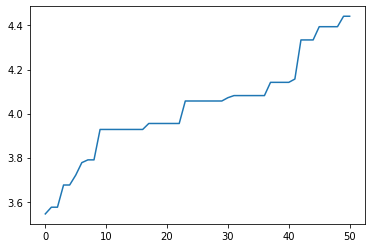

Selection: roulette - Crossover: onepoint - Mutation: position - Fitness: 4.441844450170598
Flight 13 in Zone 9 - Flight 18 in Sleeve 1 - Flight 7 in Sleeve 5 - Flight 28 in Zone 2 - Flight 3 in Sleeve 7 - Flight 20 in Zone 0 - Flight 19 in Sleeve 8 - Flight 24 in Sleeve 4 - Flight 16 in Sleeve 3 - Flight 17 in Sleeve 6



In [18]:
num_individuals = 50

fitness_fn = fitness
n_generations = 50

best_fitness = 0

selection_fn = "roulette"
crossover = "onepoint"
mutation = "position"
p_mut = 0.2

# Realiza la asignacion con el algoritmo genetico
best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, crossover, mutation, p_mut)

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

# imprime la mejor solucion
make_solution_report(best_ind, selection_fn, crossover, mutation)

### <b>Experimentación con el Algoritmo Genético 10 prubeas sin mutacion 10 pruebas con mutacion ( valores de "0.2" /"0.5"  /"0.7" /"1"</b> 

### Primeras 10 pruebas con mutacion deshabilitasa</b>


In [19]:
Ejecuciones=10
num_individuals = 50
fitness_fn = fitness
n_generations = 50

best_fitness = 0

selection_fn = "roulette"
crossover = ['uniform', 'onepoint']
mutation = "position"
p_mut = 0

df_resultados=pd.DataFrame(columns=["Tipo_cruzamiento","Best_fitness"])

Poblacion inicial, best_fitness = 3.54850619558052
generacion 0, (Mejor fitness = 3.8012948221972924)
generacion 10, (Mejor fitness = 4.769053872917538)
generacion 20, (Mejor fitness = 4.813920794713924)
generacion 30, (Mejor fitness = 4.813920794713924)
generacion 40, (Mejor fitness = 4.813920794713924)


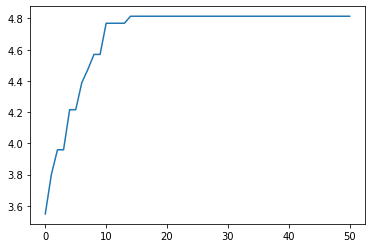

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.813920794713924
Flight 19 in Sleeve 4 - Flight 28 in Zone 9 - Flight 7 in Sleeve 1 - Flight 25 in Sleeve 6 - Flight 4 in Sleeve 7 - Flight 17 in Sleeve 8 - Flight 18 in Sleeve 3 - Flight 3 in Zone 0 - Flight 16 in Sleeve 5 - Flight 13 in Zone 2

Poblacion inicial, best_fitness = 3.4023042071523237
generacion 0, (Mejor fitness = 3.417408134935587)
generacion 10, (Mejor fitness = 4.544723427773278)
generacion 20, (Mejor fitness = 4.685472005537252)
generacion 30, (Mejor fitness = 4.685472005537252)
generacion 40, (Mejor fitness = 4.685472005537252)


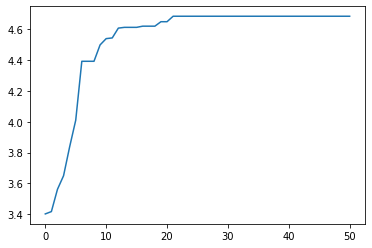

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.685472005537252
Flight 4 in Sleeve 4 - Flight 7 in Sleeve 8 - Flight 16 in Sleeve 7 - Flight 10 in Sleeve 5 - Flight 17 in Sleeve 1 - Flight 20 in Zone 0 - Flight 28 in Zone 2 - Flight 3 in Zone 9 - Flight 5 in Sleeve 3 - Flight 18 in Sleeve 6

Poblacion inicial, best_fitness = 3.446113920981873
generacion 0, (Mejor fitness = 3.446113920981873)
generacion 10, (Mejor fitness = 4.557631629309759)
generacion 20, (Mejor fitness = 4.623386989075397)
generacion 30, (Mejor fitness = 4.623386989075397)
generacion 40, (Mejor fitness = 4.623386989075397)


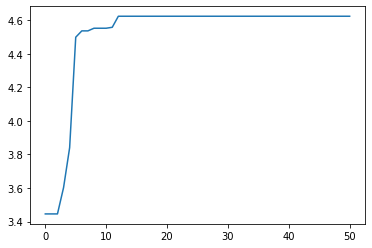

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.623386989075397
Flight 20 in Sleeve 8 - Flight 3 in Zone 2 - Flight 28 in Zone 0 - Flight 18 in Sleeve 5 - Flight 4 in Zone 9 - Flight 10 in Sleeve 3 - Flight 19 in Sleeve 4 - Flight 9 in Sleeve 1 - Flight 7 in Sleeve 6 - Flight 13 in Sleeve 7

Poblacion inicial, best_fitness = 3.5736757070975425
generacion 0, (Mejor fitness = 3.6956608822606745)
generacion 10, (Mejor fitness = 4.685482598195031)
generacion 20, (Mejor fitness = 4.801630576408611)
generacion 30, (Mejor fitness = 4.801630576408611)
generacion 40, (Mejor fitness = 4.801630576408611)


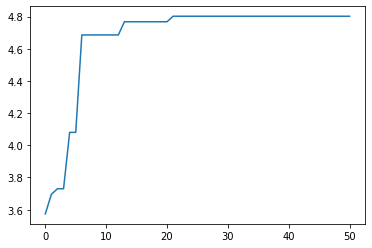

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.801630576408611
Flight 28 in Zone 9 - Flight 9 in Sleeve 8 - Flight 16 in Sleeve 6 - Flight 3 in Sleeve 1 - Flight 13 in Zone 2 - Flight 7 in Sleeve 7 - Flight 25 in Sleeve 5 - Flight 6 in Sleeve 3 - Flight 19 in Zone 0 - Flight 4 in Sleeve 4

Poblacion inicial, best_fitness = 3.3315085064887078
generacion 0, (Mejor fitness = 4.0469003241656605)
generacion 10, (Mejor fitness = 4.741119282679645)
generacion 20, (Mejor fitness = 4.806135588370765)
generacion 30, (Mejor fitness = 4.806135588370765)
generacion 40, (Mejor fitness = 4.806135588370765)


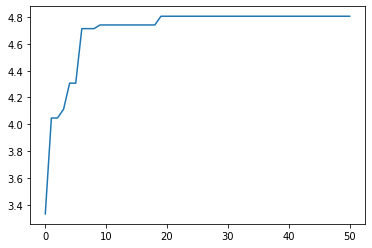

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.806135588370765
Flight 20 in Zone 0 - Flight 13 in Sleeve 7 - Flight 7 in Sleeve 6 - Flight 11 in Sleeve 8 - Flight 4 in Sleeve 4 - Flight 16 in Sleeve 5 - Flight 18 in Sleeve 1 - Flight 28 in Zone 9 - Flight 17 in Sleeve 3 - Flight 3 in Zone 2

Poblacion inicial, best_fitness = 3.3686671871189504
generacion 0, (Mejor fitness = 3.6124861135610353)
generacion 10, (Mejor fitness = 4.61386826847504)
generacion 20, (Mejor fitness = 4.731765244827949)
generacion 30, (Mejor fitness = 4.731765244827949)
generacion 40, (Mejor fitness = 4.731765244827949)


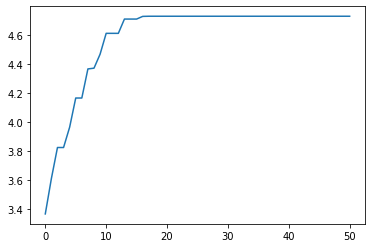

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.731765244827949
Flight 4 in Zone 2 - Flight 19 in Zone 0 - Flight 13 in Sleeve 5 - Flight 18 in Sleeve 7 - Flight 16 in Sleeve 6 - Flight 28 in Zone 9 - Flight 25 in Sleeve 8 - Flight 2 in Sleeve 3 - Flight 7 in Sleeve 1 - Flight 3 in Sleeve 4

Poblacion inicial, best_fitness = 3.436394251315189
generacion 0, (Mejor fitness = 3.6230107746253997)
generacion 10, (Mejor fitness = 4.543331892101619)
generacion 20, (Mejor fitness = 4.7031270846510695)
generacion 30, (Mejor fitness = 4.7031270846510695)
generacion 40, (Mejor fitness = 4.7031270846510695)


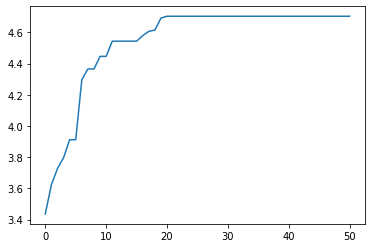

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.7031270846510695
Flight 28 in Zone 0 - Flight 3 in Sleeve 4 - Flight 25 in Sleeve 3 - Flight 12 in Sleeve 5 - Flight 20 in Zone 2 - Flight 13 in Zone 9 - Flight 18 in Sleeve 6 - Flight 7 in Sleeve 1 - Flight 16 in Sleeve 8 - Flight 9 in Sleeve 7

Poblacion inicial, best_fitness = 3.2139354905836153
generacion 0, (Mejor fitness = 3.485216860531632)
generacion 10, (Mejor fitness = 4.550920038955991)
generacion 20, (Mejor fitness = 4.675891928934772)
generacion 30, (Mejor fitness = 4.675891928934772)
generacion 40, (Mejor fitness = 4.675891928934772)


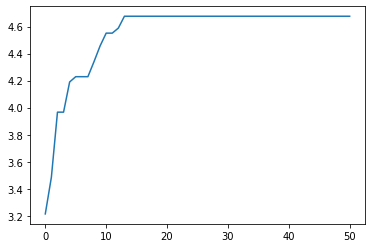

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.675891928934772
Flight 16 in Sleeve 5 - Flight 9 in Sleeve 6 - Flight 18 in Sleeve 4 - Flight 13 in Zone 0 - Flight 6 in Sleeve 1 - Flight 7 in Sleeve 3 - Flight 3 in Zone 2 - Flight 25 in Sleeve 7 - Flight 24 in Sleeve 8 - Flight 28 in Zone 9

Poblacion inicial, best_fitness = 3.585698745495844
generacion 0, (Mejor fitness = 3.585698745495844)
generacion 10, (Mejor fitness = 4.70742949224571)
generacion 20, (Mejor fitness = 4.7715102895111885)
generacion 30, (Mejor fitness = 4.7715102895111885)
generacion 40, (Mejor fitness = 4.7715102895111885)


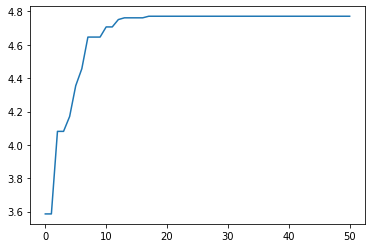

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.7715102895111885
Flight 13 in Zone 0 - Flight 4 in Sleeve 1 - Flight 7 in Sleeve 5 - Flight 6 in Sleeve 6 - Flight 28 in Zone 9 - Flight 29 in Sleeve 3 - Flight 3 in Sleeve 4 - Flight 18 in Sleeve 8 - Flight 9 in Zone 2 - Flight 16 in Sleeve 7

Poblacion inicial, best_fitness = 3.4993185671603544
generacion 0, (Mejor fitness = 3.4993185671603544)
generacion 10, (Mejor fitness = 4.523501296602995)
generacion 20, (Mejor fitness = 4.9165725642143805)
generacion 30, (Mejor fitness = 4.917178182253413)
generacion 40, (Mejor fitness = 4.917178182253413)


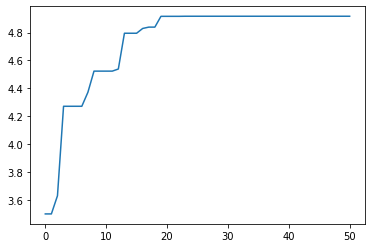

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.917178182253413
Flight 3 in Zone 9 - Flight 20 in Zone 0 - Flight 4 in Sleeve 4 - Flight 25 in Sleeve 3 - Flight 7 in Sleeve 1 - Flight 18 in Sleeve 6 - Flight 17 in Sleeve 8 - Flight 28 in Zone 2 - Flight 9 in Sleeve 7 - Flight 16 in Sleeve 5

Poblacion inicial, best_fitness = 4.023327138276591
generacion 0, (Mejor fitness = 4.023327138276591)
generacion 10, (Mejor fitness = 4.139689612811141)
generacion 20, (Mejor fitness = 4.139689612811141)
generacion 30, (Mejor fitness = 4.139689612811141)
generacion 40, (Mejor fitness = 4.139689612811141)


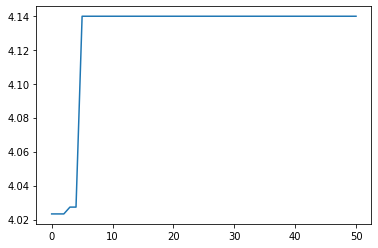

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.139689612811141
Flight 24 in Sleeve 3 - Flight 7 in Sleeve 5 - Flight 9 in Sleeve 6 - Flight 18 in Sleeve 1 - Flight 11 in Sleeve 8 - Flight 20 in Zone 2 - Flight 13 in Sleeve 4 - Flight 1 in Zone 0 - Flight 21 in Sleeve 7 - Flight 28 in Zone 9

Poblacion inicial, best_fitness = 3.9483834023606463
generacion 0, (Mejor fitness = 3.9483834023606463)
generacion 10, (Mejor fitness = 4.345601637116601)
generacion 20, (Mejor fitness = 4.345601637116601)
generacion 30, (Mejor fitness = 4.345601637116601)
generacion 40, (Mejor fitness = 4.345601637116601)


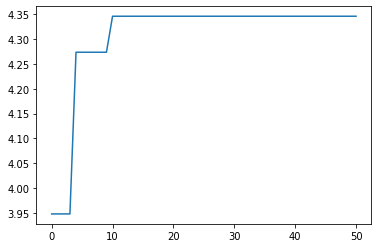

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.345601637116601
Flight 13 in Zone 0 - Flight 7 in Sleeve 6 - Flight 16 in Sleeve 5 - Flight 28 in Zone 9 - Flight 24 in Sleeve 8 - Flight 5 in Sleeve 7 - Flight 4 in Zone 2 - Flight 2 in Sleeve 3 - Flight 6 in Sleeve 4 - Flight 25 in Sleeve 1

Poblacion inicial, best_fitness = 3.4811990803521278
generacion 0, (Mejor fitness = 3.7145252350103632)
generacion 10, (Mejor fitness = 4.115493932623731)
generacion 20, (Mejor fitness = 4.115493932623731)
generacion 30, (Mejor fitness = 4.115493932623731)
generacion 40, (Mejor fitness = 4.115493932623731)


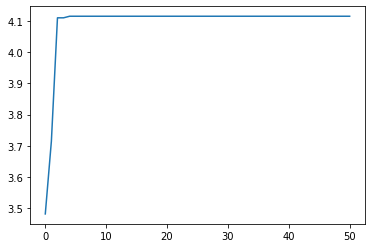

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.115493932623731
Flight 3 in Sleeve 6 - Flight 20 in Zone 0 - Flight 7 in Sleeve 4 - Flight 4 in Sleeve 1 - Flight 19 in Sleeve 3 - Flight 8 in Sleeve 5 - Flight 13 in Sleeve 7 - Flight 16 in Zone 2 - Flight 5 in Sleeve 8 - Flight 28 in Zone 9

Poblacion inicial, best_fitness = 3.832181519046229
generacion 0, (Mejor fitness = 4.0073601399016345)
generacion 10, (Mejor fitness = 4.244168715773189)
generacion 20, (Mejor fitness = 4.371252076564543)
generacion 30, (Mejor fitness = 4.371252076564543)
generacion 40, (Mejor fitness = 4.371252076564543)


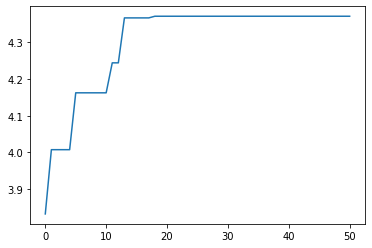

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.371252076564543
Flight 16 in Sleeve 8 - Flight 18 in Sleeve 1 - Flight 28 in Zone 9 - Flight 20 in Sleeve 3 - Flight 11 in Sleeve 7 - Flight 17 in Zone 0 - Flight 7 in Sleeve 5 - Flight 3 in Zone 2 - Flight 9 in Sleeve 4 - Flight 12 in Sleeve 6

Poblacion inicial, best_fitness = 3.6159507263723167
generacion 0, (Mejor fitness = 3.6159507263723167)
generacion 10, (Mejor fitness = 4.4574681857165555)
generacion 20, (Mejor fitness = 4.4574681857165555)
generacion 30, (Mejor fitness = 4.4574681857165555)
generacion 40, (Mejor fitness = 4.4574681857165555)


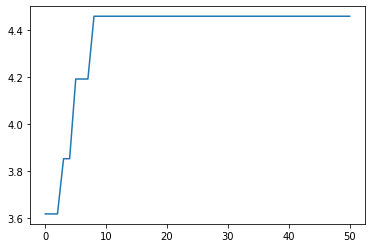

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.4574681857165555
Flight 9 in Sleeve 4 - Flight 28 in Zone 9 - Flight 13 in Zone 2 - Flight 17 in Sleeve 8 - Flight 7 in Sleeve 6 - Flight 5 in Sleeve 7 - Flight 18 in Sleeve 3 - Flight 16 in Sleeve 5 - Flight 20 in Zone 0 - Flight 12 in Sleeve 1

Poblacion inicial, best_fitness = 3.5189670165279634
generacion 0, (Mejor fitness = 3.5189670165279634)
generacion 10, (Mejor fitness = 3.9399370287527757)
generacion 20, (Mejor fitness = 3.9399370287527757)
generacion 30, (Mejor fitness = 3.9399370287527757)
generacion 40, (Mejor fitness = 3.9399370287527757)


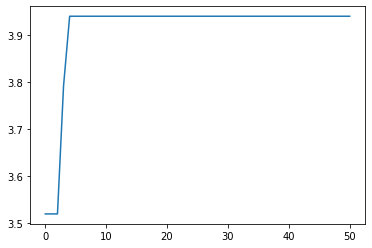

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 3.9399370287527757
Flight 9 in Sleeve 4 - Flight 28 in Zone 9 - Flight 18 in Sleeve 8 - Flight 3 in Sleeve 6 - Flight 24 in Zone 2 - Flight 27 in Sleeve 5 - Flight 23 in Sleeve 3 - Flight 20 in Sleeve 1 - Flight 17 in Sleeve 7 - Flight 1 in Zone 0

Poblacion inicial, best_fitness = 3.3960729314440954
generacion 0, (Mejor fitness = 3.973626507915949)
generacion 10, (Mejor fitness = 4.504940721449166)
generacion 20, (Mejor fitness = 4.504940721449166)
generacion 30, (Mejor fitness = 4.504940721449166)
generacion 40, (Mejor fitness = 4.504940721449166)


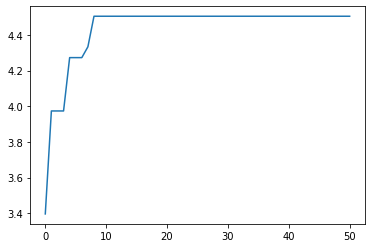

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.504940721449166
Flight 13 in Sleeve 6 - Flight 27 in Sleeve 1 - Flight 20 in Sleeve 8 - Flight 9 in Sleeve 3 - Flight 28 in Zone 2 - Flight 4 in Zone 9 - Flight 18 in Sleeve 5 - Flight 3 in Zone 0 - Flight 12 in Sleeve 7 - Flight 7 in Sleeve 4

Poblacion inicial, best_fitness = 3.717514573878371
generacion 0, (Mejor fitness = 4.013721877562647)
generacion 10, (Mejor fitness = 4.266272855971478)
generacion 20, (Mejor fitness = 4.294036611650428)
generacion 30, (Mejor fitness = 4.294036611650428)
generacion 40, (Mejor fitness = 4.294036611650428)


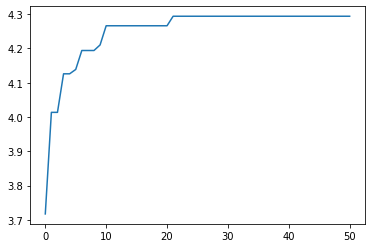

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.294036611650428
Flight 18 in Sleeve 7 - Flight 25 in Sleeve 5 - Flight 4 in Sleeve 4 - Flight 6 in Sleeve 6 - Flight 3 in Zone 9 - Flight 16 in Sleeve 8 - Flight 9 in Zone 0 - Flight 13 in Zone 2 - Flight 1 in Sleeve 1 - Flight 12 in Sleeve 3

Poblacion inicial, best_fitness = 3.6830226918086213
generacion 0, (Mejor fitness = 3.7297428277421245)
generacion 10, (Mejor fitness = 4.120419491815568)
generacion 20, (Mejor fitness = 4.120419491815568)
generacion 30, (Mejor fitness = 4.120419491815568)
generacion 40, (Mejor fitness = 4.120419491815568)


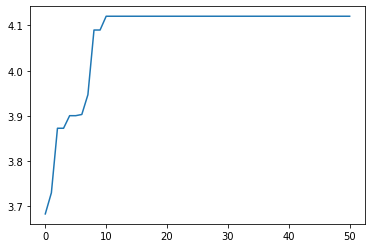

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.120419491815568
Flight 6 in Sleeve 7 - Flight 12 in Zone 9 - Flight 18 in Sleeve 3 - Flight 16 in Sleeve 5 - Flight 19 in Sleeve 1 - Flight 20 in Zone 2 - Flight 9 in Sleeve 4 - Flight 4 in Sleeve 6 - Flight 7 in Sleeve 8 - Flight 28 in Zone 0

Poblacion inicial, best_fitness = 3.789302059935836
generacion 0, (Mejor fitness = 3.789302059935836)
generacion 10, (Mejor fitness = 4.3428128795237955)
generacion 20, (Mejor fitness = 4.3428128795237955)
generacion 30, (Mejor fitness = 4.3428128795237955)
generacion 40, (Mejor fitness = 4.3428128795237955)


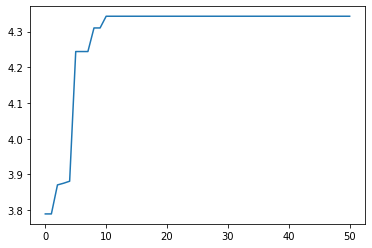

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.3428128795237955
Flight 3 in Sleeve 6 - Flight 18 in Zone 0 - Flight 28 in Zone 2 - Flight 7 in Sleeve 1 - Flight 9 in Sleeve 8 - Flight 19 in Zone 9 - Flight 26 in Sleeve 5 - Flight 12 in Sleeve 7 - Flight 5 in Sleeve 3 - Flight 4 in Sleeve 4



,Tipo_cruzamiento,Best_fitness
0,uniform,4.753002
1,onepoint,4.263165


In [20]:
temporal= {} 

for cross in crossover : 
      dic_fitness = [ ] 
      for i in range(Ejecuciones):                
             # Realiza la asignacion con el algoritmo genetico
              best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, cross, mutation, p_mut)
              dic_fitness.append(bestfitness[-1])
              # muestra la evolucion del mejor fitness
              plt.plot(bestfitness)
              plt.show()

              # imprime la mejor solucion
              make_solution_report(best_ind, selection_fn, crossover, mutation)
      meanfitness = sum(dic_fitness) / len(dic_fitness)
      temporal={'Tipo_cruzamiento':cross,'Best_fitness':meanfitness}
      df_resultados=df_resultados.append(temporal, ignore_index = True)
df_resultados

### 10 pruebas con mutacion </b>


In [21]:
Ejecuciones=10
num_individuals = 50
fitness_fn = fitness
n_generations = 50

best_fitness = 0

selection_fn = "roulette"
crossover = ['uniform', 'onepoint']
mutation = "position"
p_mut = {0.2,0.8 }

df_resultados=pd.DataFrame(columns=["Tipo_cruzamiento","Pmut","Best_fitness"])

Poblacion inicial, best_fitness = 3.4345681278358726
generacion 0, (Mejor fitness = 3.7423382014397824)
generacion 10, (Mejor fitness = 4.519454851144622)
generacion 20, (Mejor fitness = 4.798055724589782)
generacion 30, (Mejor fitness = 4.8646421754583455)
generacion 40, (Mejor fitness = 4.8646421754583455)


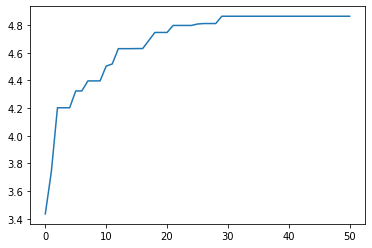

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.8646421754583455
Flight 12 in Sleeve 5 - Flight 6 in Sleeve 6 - Flight 13 in Zone 9 - Flight 4 in Sleeve 4 - Flight 9 in Sleeve 8 - Flight 18 in Sleeve 3 - Flight 16 in Sleeve 7 - Flight 3 in Zone 0 - Flight 28 in Zone 2 - Flight 7 in Sleeve 1

Poblacion inicial, best_fitness = 3.407468353142985
generacion 0, (Mejor fitness = 3.9908827813229872)
generacion 10, (Mejor fitness = 4.688503175798185)
generacion 20, (Mejor fitness = 4.834566083597399)
generacion 30, (Mejor fitness = 4.834566083597399)
generacion 40, (Mejor fitness = 4.834566083597399)


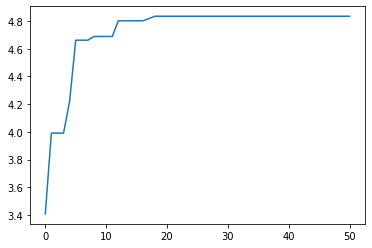

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.834566083597399
Flight 16 in Sleeve 3 - Flight 12 in Sleeve 5 - Flight 28 in Zone 9 - Flight 3 in Zone 0 - Flight 13 in Zone 2 - Flight 19 in Sleeve 1 - Flight 25 in Sleeve 7 - Flight 7 in Sleeve 4 - Flight 4 in Sleeve 8 - Flight 18 in Sleeve 6

Poblacion inicial, best_fitness = 3.856959780456682
generacion 0, (Mejor fitness = 4.116582260369944)
generacion 10, (Mejor fitness = 4.823993726907584)
generacion 20, (Mejor fitness = 4.8500505054523595)
generacion 30, (Mejor fitness = 4.8500505054523595)
generacion 40, (Mejor fitness = 4.8500505054523595)


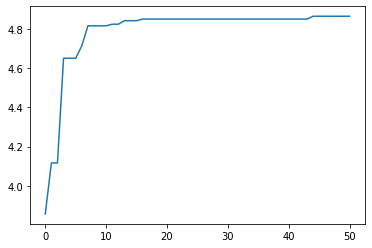

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.8645992925059724
Flight 25 in Sleeve 6 - Flight 28 in Zone 2 - Flight 18 in Sleeve 7 - Flight 27 in Sleeve 5 - Flight 9 in Sleeve 4 - Flight 3 in Zone 9 - Flight 13 in Zone 0 - Flight 7 in Sleeve 1 - Flight 16 in Sleeve 3 - Flight 6 in Sleeve 8

Poblacion inicial, best_fitness = 3.456229437078836
generacion 0, (Mejor fitness = 3.4718562021473396)
generacion 10, (Mejor fitness = 4.32090157183024)
generacion 20, (Mejor fitness = 4.759149584581984)
generacion 30, (Mejor fitness = 4.7873635647588975)
generacion 40, (Mejor fitness = 4.7873635647588975)


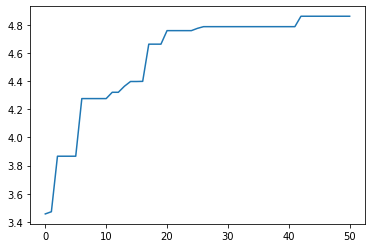

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.861429497705063
Flight 28 in Zone 2 - Flight 4 in Sleeve 6 - Flight 25 in Sleeve 3 - Flight 7 in Sleeve 1 - Flight 16 in Sleeve 5 - Flight 3 in Zone 0 - Flight 20 in Zone 9 - Flight 17 in Sleeve 8 - Flight 18 in Sleeve 7 - Flight 9 in Sleeve 4

Poblacion inicial, best_fitness = 4.170116099277223
generacion 0, (Mejor fitness = 4.170116099277223)
generacion 10, (Mejor fitness = 4.516219677091815)
generacion 20, (Mejor fitness = 4.655807456959369)
generacion 30, (Mejor fitness = 4.735049475535156)
generacion 40, (Mejor fitness = 4.8679869443720065)


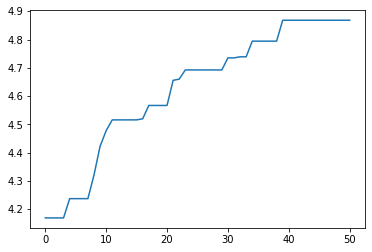

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.8679869443720065
Flight 7 in Sleeve 7 - Flight 17 in Sleeve 1 - Flight 18 in Sleeve 6 - Flight 16 in Sleeve 5 - Flight 28 in Zone 9 - Flight 29 in Sleeve 3 - Flight 3 in Zone 0 - Flight 25 in Sleeve 8 - Flight 13 in Zone 2 - Flight 4 in Sleeve 4

Poblacion inicial, best_fitness = 3.587095906062685
generacion 0, (Mejor fitness = 3.587095906062685)
generacion 10, (Mejor fitness = 4.593479956856591)
generacion 20, (Mejor fitness = 4.787698895714408)
generacion 30, (Mejor fitness = 4.804154723481579)
generacion 40, (Mejor fitness = 4.89999652682601)


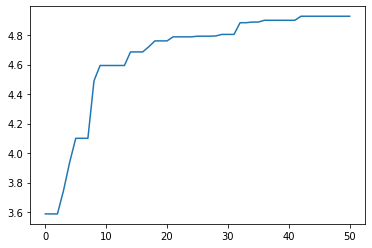

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.927382846315491
Flight 28 in Zone 2 - Flight 13 in Zone 0 - Flight 16 in Sleeve 7 - Flight 9 in Sleeve 4 - Flight 7 in Sleeve 5 - Flight 3 in Zone 9 - Flight 25 in Sleeve 1 - Flight 4 in Sleeve 6 - Flight 18 in Sleeve 8 - Flight 12 in Sleeve 3

Poblacion inicial, best_fitness = 3.943695079083297
generacion 0, (Mejor fitness = 3.943695079083297)
generacion 10, (Mejor fitness = 4.580307215192583)
generacion 20, (Mejor fitness = 4.928090202670291)
generacion 30, (Mejor fitness = 4.9365216689022695)
generacion 40, (Mejor fitness = 4.9365216689022695)


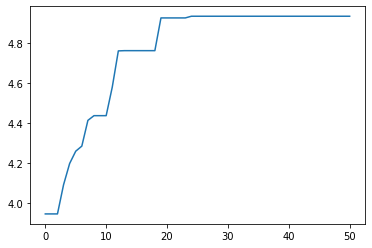

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.9365216689022695
Flight 18 in Sleeve 6 - Flight 25 in Sleeve 5 - Flight 6 in Sleeve 3 - Flight 28 in Zone 9 - Flight 4 in Sleeve 1 - Flight 7 in Sleeve 4 - Flight 12 in Sleeve 7 - Flight 13 in Zone 2 - Flight 3 in Zone 0 - Flight 19 in Sleeve 8

Poblacion inicial, best_fitness = 3.664913211083
generacion 0, (Mejor fitness = 4.025003182577524)
generacion 10, (Mejor fitness = 4.5264755571822475)
generacion 20, (Mejor fitness = 4.830491101272059)
generacion 30, (Mejor fitness = 4.830491101272059)
generacion 40, (Mejor fitness = 4.864156530337167)


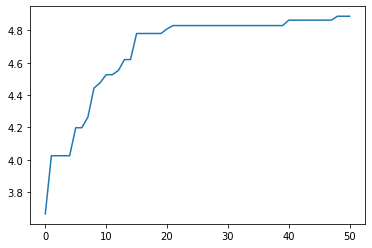

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.888210793667875
Flight 3 in Sleeve 4 - Flight 25 in Sleeve 5 - Flight 20 in Zone 0 - Flight 12 in Sleeve 3 - Flight 16 in Sleeve 8 - Flight 28 in Zone 9 - Flight 4 in Sleeve 1 - Flight 18 in Sleeve 6 - Flight 7 in Sleeve 7 - Flight 13 in Zone 2

Poblacion inicial, best_fitness = 3.67870014333848
generacion 0, (Mejor fitness = 3.820312294477444)
generacion 10, (Mejor fitness = 4.667270008118818)
generacion 20, (Mejor fitness = 4.820096322947554)
generacion 30, (Mejor fitness = 4.8854812722619245)
generacion 40, (Mejor fitness = 4.8854812722619245)


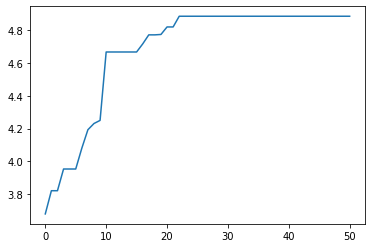

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.8854812722619245
Flight 19 in Zone 0 - Flight 3 in Zone 9 - Flight 28 in Zone 2 - Flight 6 in Sleeve 8 - Flight 5 in Sleeve 3 - Flight 25 in Sleeve 6 - Flight 18 in Sleeve 7 - Flight 4 in Sleeve 4 - Flight 13 in Sleeve 1 - Flight 7 in Sleeve 5

Poblacion inicial, best_fitness = 3.474849182173779
generacion 0, (Mejor fitness = 3.7715572085735896)
generacion 10, (Mejor fitness = 4.5277074091126215)
generacion 20, (Mejor fitness = 4.643608474653069)
generacion 30, (Mejor fitness = 4.701653743848645)
generacion 40, (Mejor fitness = 4.701653743848645)


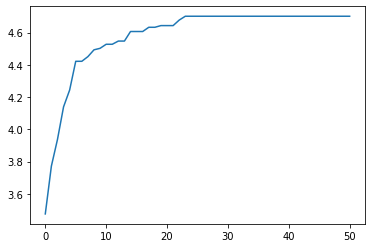

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.701653743848645
Flight 3 in Zone 9 - Flight 4 in Sleeve 1 - Flight 9 in Sleeve 6 - Flight 7 in Sleeve 4 - Flight 16 in Sleeve 5 - Flight 18 in Sleeve 8 - Flight 25 in Sleeve 3 - Flight 24 in Zone 2 - Flight 20 in Sleeve 7 - Flight 28 in Zone 0

Poblacion inicial, best_fitness = 3.593733934961773
generacion 0, (Mejor fitness = 4.2427117241072105)
generacion 10, (Mejor fitness = 4.2427117241072105)
generacion 20, (Mejor fitness = 4.488662410861297)
generacion 30, (Mejor fitness = 4.64179384479311)
generacion 40, (Mejor fitness = 4.738713197737538)


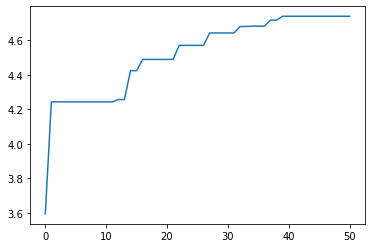

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.738713197737538
Flight 3 in Zone 9 - Flight 24 in Sleeve 8 - Flight 17 in Sleeve 5 - Flight 6 in Sleeve 3 - Flight 7 in Sleeve 6 - Flight 13 in Zone 2 - Flight 19 in Sleeve 4 - Flight 28 in Zone 0 - Flight 25 in Sleeve 7 - Flight 4 in Sleeve 1

Poblacion inicial, best_fitness = 3.8455690534472713
generacion 0, (Mejor fitness = 3.8455690534472713)
generacion 10, (Mejor fitness = 4.170138766534632)
generacion 20, (Mejor fitness = 4.416138380297351)
generacion 30, (Mejor fitness = 4.611548858900337)
generacion 40, (Mejor fitness = 4.646729420211838)


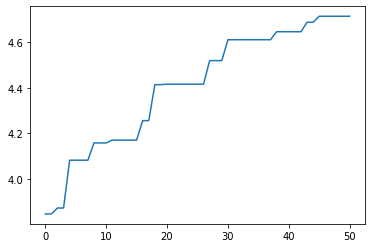

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.714805530670091
Flight 4 in Sleeve 4 - Flight 20 in Zone 9 - Flight 6 in Sleeve 6 - Flight 13 in Sleeve 7 - Flight 28 in Zone 0 - Flight 3 in Zone 2 - Flight 12 in Sleeve 8 - Flight 25 in Sleeve 5 - Flight 7 in Sleeve 1 - Flight 26 in Sleeve 3

Poblacion inicial, best_fitness = 3.7397392026084972
generacion 0, (Mejor fitness = 3.7397392026084972)
generacion 10, (Mejor fitness = 4.199541846396709)
generacion 20, (Mejor fitness = 4.4302670138328635)
generacion 30, (Mejor fitness = 4.540502221078938)
generacion 40, (Mejor fitness = 4.619986645247719)


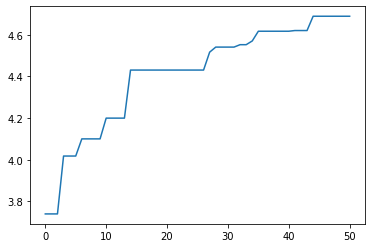

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.688609111553578
Flight 28 in Zone 2 - Flight 25 in Sleeve 7 - Flight 6 in Sleeve 8 - Flight 7 in Sleeve 5 - Flight 4 in Sleeve 4 - Flight 21 in Sleeve 6 - Flight 13 in Zone 9 - Flight 19 in Zone 0 - Flight 3 in Sleeve 1 - Flight 18 in Sleeve 3

Poblacion inicial, best_fitness = 3.603642460768495
generacion 0, (Mejor fitness = 3.6132344029448284)
generacion 10, (Mejor fitness = 4.3929760423554205)
generacion 20, (Mejor fitness = 4.552700062285149)
generacion 30, (Mejor fitness = 4.552700062285149)
generacion 40, (Mejor fitness = 4.731481531947025)


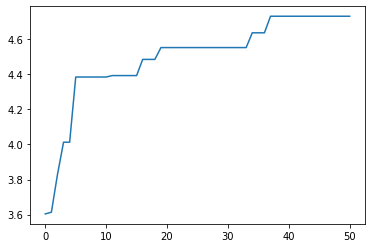

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.731481531947025
Flight 28 in Zone 0 - Flight 7 in Sleeve 4 - Flight 13 in Zone 2 - Flight 9 in Sleeve 5 - Flight 3 in Zone 9 - Flight 16 in Sleeve 1 - Flight 25 in Sleeve 3 - Flight 22 in Sleeve 8 - Flight 17 in Sleeve 6 - Flight 18 in Sleeve 7

Poblacion inicial, best_fitness = 3.4341709586801628
generacion 0, (Mejor fitness = 3.7074963708616386)
generacion 10, (Mejor fitness = 4.3956409477081495)
generacion 20, (Mejor fitness = 4.678240217640197)
generacion 30, (Mejor fitness = 4.678240217640197)
generacion 40, (Mejor fitness = 4.699238932299223)


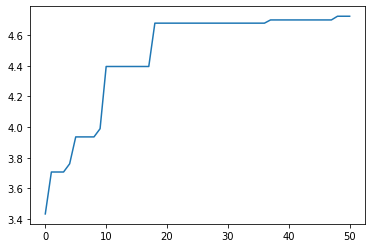

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.72332906093502
Flight 24 in Sleeve 6 - Flight 3 in Zone 9 - Flight 6 in Sleeve 8 - Flight 18 in Sleeve 1 - Flight 16 in Sleeve 5 - Flight 9 in Sleeve 7 - Flight 28 in Zone 2 - Flight 17 in Sleeve 3 - Flight 20 in Zone 0 - Flight 7 in Sleeve 4

Poblacion inicial, best_fitness = 3.511907717904991
generacion 0, (Mejor fitness = 3.6259727073821706)
generacion 10, (Mejor fitness = 4.1532767806753945)
generacion 20, (Mejor fitness = 4.484808777559412)
generacion 30, (Mejor fitness = 4.687830860504602)
generacion 40, (Mejor fitness = 4.689910316417313)


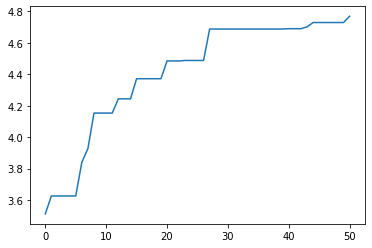

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.769084409117478
Flight 25 in Sleeve 1 - Flight 20 in Zone 2 - Flight 13 in Sleeve 5 - Flight 28 in Zone 0 - Flight 7 in Sleeve 7 - Flight 3 in Zone 9 - Flight 4 in Sleeve 4 - Flight 18 in Sleeve 6 - Flight 5 in Sleeve 3 - Flight 16 in Sleeve 8

Poblacion inicial, best_fitness = 3.585383966795914
generacion 0, (Mejor fitness = 3.585383966795914)
generacion 10, (Mejor fitness = 4.135869290979444)
generacion 20, (Mejor fitness = 4.267207997639487)
generacion 30, (Mejor fitness = 4.3909977854942435)
generacion 40, (Mejor fitness = 4.519271929655718)


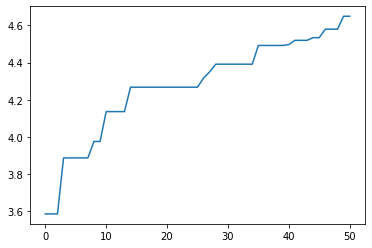

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.648983818628737
Flight 28 in Zone 0 - Flight 11 in Sleeve 3 - Flight 19 in Sleeve 6 - Flight 10 in Sleeve 7 - Flight 4 in Zone 2 - Flight 17 in Sleeve 8 - Flight 7 in Sleeve 4 - Flight 3 in Zone 9 - Flight 18 in Sleeve 1 - Flight 25 in Sleeve 5

Poblacion inicial, best_fitness = 3.4909222684787693
generacion 0, (Mejor fitness = 3.4909222684787693)
generacion 10, (Mejor fitness = 4.226608328895603)
generacion 20, (Mejor fitness = 4.447832872001723)
generacion 30, (Mejor fitness = 4.686512174549709)
generacion 40, (Mejor fitness = 4.833982214939667)


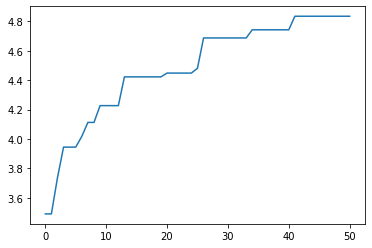

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.833982214939667
Flight 3 in Sleeve 4 - Flight 17 in Sleeve 5 - Flight 18 in Sleeve 8 - Flight 7 in Sleeve 6 - Flight 13 in Zone 0 - Flight 4 in Sleeve 1 - Flight 28 in Zone 9 - Flight 6 in Sleeve 7 - Flight 25 in Sleeve 3 - Flight 19 in Zone 2

Poblacion inicial, best_fitness = 3.562166992673611
generacion 0, (Mejor fitness = 3.847241722563568)
generacion 10, (Mejor fitness = 4.329540144615454)
generacion 20, (Mejor fitness = 4.619814380239038)
generacion 30, (Mejor fitness = 4.826702615622765)
generacion 40, (Mejor fitness = 4.826702615622765)


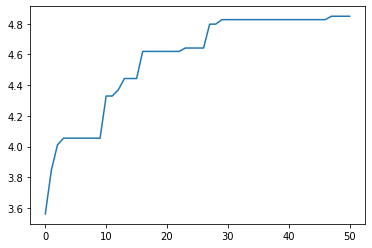

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.848818534416465
Flight 13 in Zone 0 - Flight 10 in Sleeve 3 - Flight 18 in Sleeve 4 - Flight 6 in Sleeve 7 - Flight 7 in Sleeve 5 - Flight 19 in Sleeve 6 - Flight 4 in Sleeve 1 - Flight 3 in Zone 9 - Flight 28 in Zone 2 - Flight 16 in Sleeve 8

Poblacion inicial, best_fitness = 3.576045339762257
generacion 0, (Mejor fitness = 3.71003503369932)
generacion 10, (Mejor fitness = 4.172854082534098)
generacion 20, (Mejor fitness = 4.750269287312626)
generacion 30, (Mejor fitness = 4.750269287312626)
generacion 40, (Mejor fitness = 4.868073874795855)


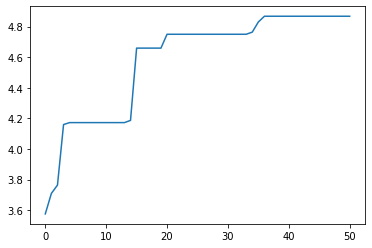

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.868073874795855
Flight 25 in Sleeve 6 - Flight 9 in Sleeve 1 - Flight 12 in Sleeve 8 - Flight 3 in Zone 0 - Flight 13 in Zone 2 - Flight 18 in Sleeve 7 - Flight 4 in Sleeve 4 - Flight 16 in Sleeve 5 - Flight 5 in Sleeve 3 - Flight 28 in Zone 9

Poblacion inicial, best_fitness = 3.5112158401832807
generacion 0, (Mejor fitness = 3.72846007723343)
generacion 10, (Mejor fitness = 4.655168171839601)
generacion 20, (Mejor fitness = 4.660640158629339)
generacion 30, (Mejor fitness = 4.789771892271046)
generacion 40, (Mejor fitness = 4.820810388866226)


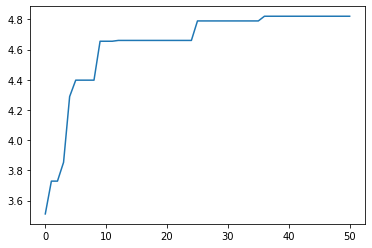

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.820810388866226
Flight 3 in Zone 0 - Flight 20 in Zone 2 - Flight 4 in Sleeve 4 - Flight 7 in Sleeve 1 - Flight 28 in Zone 9 - Flight 18 in Sleeve 6 - Flight 10 in Sleeve 3 - Flight 24 in Sleeve 7 - Flight 9 in Sleeve 8 - Flight 16 in Sleeve 5

Poblacion inicial, best_fitness = 3.6595144283943513
generacion 0, (Mejor fitness = 3.758342433570213)
generacion 10, (Mejor fitness = 4.165194880104957)
generacion 20, (Mejor fitness = 4.165194880104957)
generacion 30, (Mejor fitness = 4.165194880104957)
generacion 40, (Mejor fitness = 4.1904099033436495)


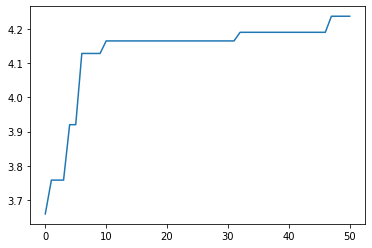

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.237375002864123
Flight 7 in Sleeve 8 - Flight 3 in Sleeve 5 - Flight 25 in Zone 2 - Flight 4 in Zone 0 - Flight 28 in Zone 9 - Flight 10 in Sleeve 7 - Flight 18 in Sleeve 3 - Flight 16 in Sleeve 1 - Flight 6 in Sleeve 6 - Flight 9 in Sleeve 4

Poblacion inicial, best_fitness = 3.883095243054766
generacion 0, (Mejor fitness = 3.9068452919857686)
generacion 10, (Mejor fitness = 4.325222014190686)
generacion 20, (Mejor fitness = 4.329046993374127)
generacion 30, (Mejor fitness = 4.339855444160477)
generacion 40, (Mejor fitness = 4.413515909377895)


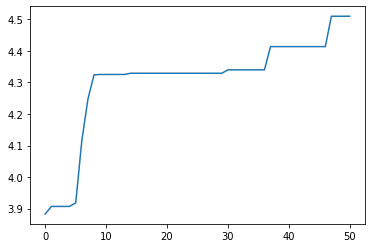

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.509796269454986
Flight 24 in Sleeve 6 - Flight 13 in Zone 0 - Flight 10 in Sleeve 3 - Flight 3 in Zone 9 - Flight 28 in Zone 2 - Flight 18 in Sleeve 5 - Flight 25 in Sleeve 8 - Flight 20 in Sleeve 1 - Flight 16 in Sleeve 4 - Flight 9 in Sleeve 7

Poblacion inicial, best_fitness = 3.6313141753191225
generacion 0, (Mejor fitness = 3.7989567372439956)
generacion 10, (Mejor fitness = 4.329490835709802)
generacion 20, (Mejor fitness = 4.696342029628664)
generacion 30, (Mejor fitness = 4.781241339032284)
generacion 40, (Mejor fitness = 4.781241339032284)


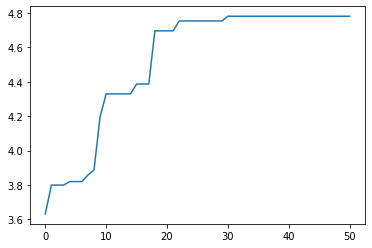

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.781241339032284
Flight 18 in Sleeve 6 - Flight 12 in Sleeve 3 - Flight 7 in Sleeve 5 - Flight 13 in Sleeve 4 - Flight 10 in Sleeve 8 - Flight 25 in Sleeve 1 - Flight 16 in Sleeve 7 - Flight 3 in Zone 2 - Flight 28 in Zone 9 - Flight 20 in Zone 0

Poblacion inicial, best_fitness = 3.7017635238351323
generacion 0, (Mejor fitness = 3.7017635238351323)
generacion 10, (Mejor fitness = 4.505363568866654)
generacion 20, (Mejor fitness = 4.568136608857669)
generacion 30, (Mejor fitness = 4.576405225460617)
generacion 40, (Mejor fitness = 4.576405225460617)


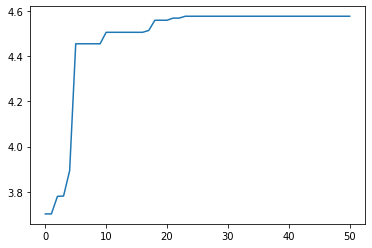

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.576405225460617
Flight 18 in Sleeve 8 - Flight 16 in Sleeve 6 - Flight 28 in Zone 2 - Flight 1 in Sleeve 7 - Flight 13 in Zone 0 - Flight 9 in Sleeve 1 - Flight 24 in Sleeve 3 - Flight 19 in Sleeve 4 - Flight 4 in Sleeve 5 - Flight 3 in Zone 9

Poblacion inicial, best_fitness = 3.332879888481334
generacion 0, (Mejor fitness = 3.3985809409055183)
generacion 10, (Mejor fitness = 4.179354494265152)
generacion 20, (Mejor fitness = 4.232990862713979)
generacion 30, (Mejor fitness = 4.3030826077442015)
generacion 40, (Mejor fitness = 4.323912270758321)


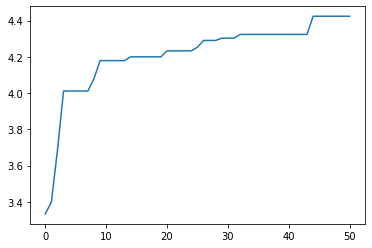

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.424272556284689
Flight 7 in Sleeve 3 - Flight 13 in Zone 0 - Flight 28 in Zone 2 - Flight 9 in Sleeve 6 - Flight 4 in Zone 9 - Flight 19 in Sleeve 4 - Flight 6 in Sleeve 7 - Flight 18 in Sleeve 1 - Flight 10 in Sleeve 8 - Flight 3 in Sleeve 5

Poblacion inicial, best_fitness = 3.684884456199244
generacion 0, (Mejor fitness = 3.684884456199244)
generacion 10, (Mejor fitness = 4.136925044065025)
generacion 20, (Mejor fitness = 4.136925044065025)
generacion 30, (Mejor fitness = 4.140709237309905)
generacion 40, (Mejor fitness = 4.233660208453972)


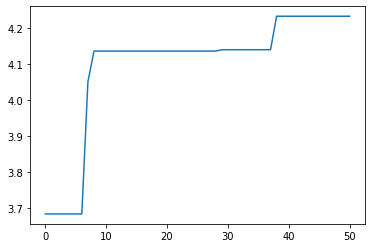

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.233660208453972
Flight 28 in Zone 0 - Flight 25 in Sleeve 3 - Flight 17 in Sleeve 5 - Flight 22 in Sleeve 6 - Flight 20 in Sleeve 4 - Flight 9 in Sleeve 1 - Flight 4 in Zone 2 - Flight 18 in Sleeve 8 - Flight 3 in Sleeve 7 - Flight 13 in Zone 9

Poblacion inicial, best_fitness = 3.6661872297204385
generacion 0, (Mejor fitness = 3.9771377783781037)
generacion 10, (Mejor fitness = 4.56523955027448)
generacion 20, (Mejor fitness = 4.649858319340899)
generacion 30, (Mejor fitness = 4.672214679725427)
generacion 40, (Mejor fitness = 4.69366421993453)


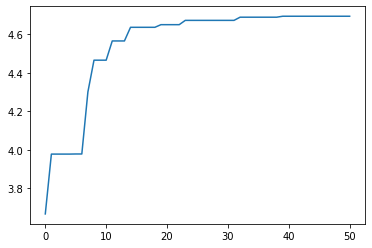

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.69366421993453
Flight 18 in Sleeve 8 - Flight 6 in Sleeve 6 - Flight 7 in Sleeve 1 - Flight 3 in Zone 9 - Flight 25 in Sleeve 4 - Flight 4 in Zone 0 - Flight 5 in Sleeve 3 - Flight 9 in Sleeve 7 - Flight 28 in Zone 2 - Flight 16 in Sleeve 5

Poblacion inicial, best_fitness = 3.734558747293338
generacion 0, (Mejor fitness = 3.7361538001748813)
generacion 10, (Mejor fitness = 4.312129314715811)
generacion 20, (Mejor fitness = 4.372617553892866)
generacion 30, (Mejor fitness = 4.372617553892866)
generacion 40, (Mejor fitness = 4.4245903154092385)


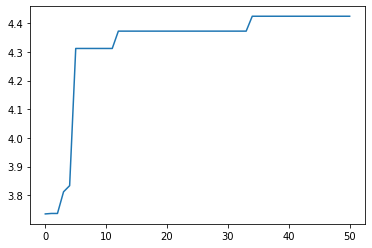

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.4245903154092385
Flight 28 in Zone 9 - Flight 2 in Sleeve 3 - Flight 9 in Sleeve 7 - Flight 18 in Zone 2 - Flight 27 in Sleeve 6 - Flight 1 in Sleeve 8 - Flight 20 in Zone 0 - Flight 25 in Sleeve 5 - Flight 7 in Sleeve 4 - Flight 3 in Sleeve 1

Poblacion inicial, best_fitness = 3.4294778615854127
generacion 0, (Mejor fitness = 3.6401366689959165)
generacion 10, (Mejor fitness = 4.158152571880545)
generacion 20, (Mejor fitness = 4.472859696075575)
generacion 30, (Mejor fitness = 4.542602186361306)
generacion 40, (Mejor fitness = 4.542602186361306)


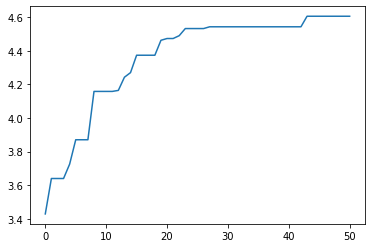

Selection: roulette - Crossover: ['uniform', 'onepoint'] - Mutation: position - Fitness: 4.605341402566869
Flight 4 in Sleeve 6 - Flight 9 in Sleeve 1 - Flight 17 in Sleeve 7 - Flight 18 in Sleeve 4 - Flight 28 in Zone 2 - Flight 3 in Zone 0 - Flight 16 in Sleeve 3 - Flight 6 in Sleeve 5 - Flight 25 in Sleeve 8 - Flight 19 in Zone 9

Poblacion inicial, best_fitness = 3.488297099490207
generacion 0, (Mejor fitness = 3.6596498370192942)


In [ ]:
temporal= {} 

for cross in crossover : 
   for pmut in p_mut:   
      dic_fitness = [ ] 
      for i in range(Ejecuciones):                
             # Realiza la asignacion con el algoritmo genetico
              best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, cross, mutation, pmut)
              dic_fitness.append(bestfitness[-1])
              # muestra la evolucion del mejor fitness
              plt.plot(bestfitness)
              plt.show()

              # imprime la mejor solucion
              make_solution_report(best_ind, selection_fn, crossover, mutation)
      meanfitness = sum(dic_fitness) / len(dic_fitness)
      temporal={'Tipo_cruzamiento':cross,'Pmut':pmut,'Best_fitness':meanfitness}
      df_resultados=df_resultados.append(temporal, ignore_index = True)
df_resultados